## Graph Signal Interpolation


The goal of this assignment is to simulate the graph interpolation problem introduced in HW4. Some graph signal processing tasks are done by PyGSP package developed by LTS2 lab. The documentations can be found [here](https://pygsp.readthedocs.io/en/stable/index.html). However, this assignment is self-contained and you don't need any further knowledge of PyGSP.

In [15]:
# Installing PyGSP and cvxpy
! pip install --upgrade pip
! pip install PyGSP
! pip install cvxpy

In [5]:
# Importing necessary packages 
import pygsp as gsp
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Setting default plotting parameters
gsp.plotting.BACKEND = 'matplotlib'

# You can change figsize if you want.
plt.rcParams['figure.figsize'] = (10, 5)

First we need to define a graph. Here a sensor network graph with 100 sensors is used.

In [10]:
N = 100
# Define the graph
G = gsp.graphs.DavidSensorNet(N, seed=1)
G.estimate_lmax()

# You can access the grap laplacian using G.L
L = G.L.toarray()

/home/ehsan/anaconda3/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


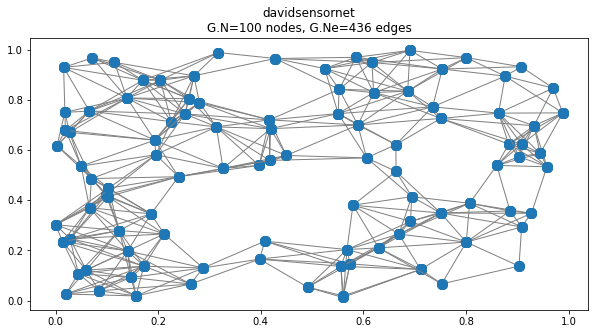

In [11]:
G.plot()

Now we need a smooth signal on the graph. First a non-smooth signal is defined and then it's filtered with a low-pass filter. Parameter τ controls bandwidth of the filter. As τ is increased, the output of the filter will be smoother.

In [17]:
non_smooth_signal = np.zeros((N,))

# non-smooth signal:
deltas = np.array([i for i in range(0, N, 10)])
non_smooth_signal[deltas] = 10

# low pass filter
lpf1 = gsp.filters.Heat(G, tau=5)
lpf2 = gsp.filters.Heat(G, tau=30)
lpf3 = gsp.filters.Heat(G, tau=100)

# filtering the signal
f1 = lpf1.filter(non_smooth_signal)
f2 = lpf2.filter(non_smooth_signal)
f3 = lpf3.filter(non_smooth_signal)

/home/ehsan/anaconda3/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


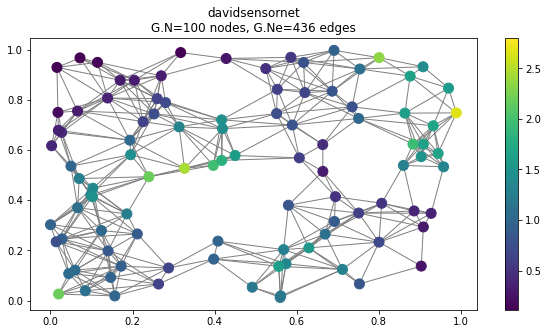

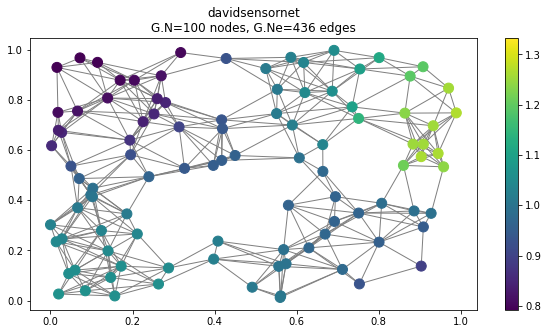

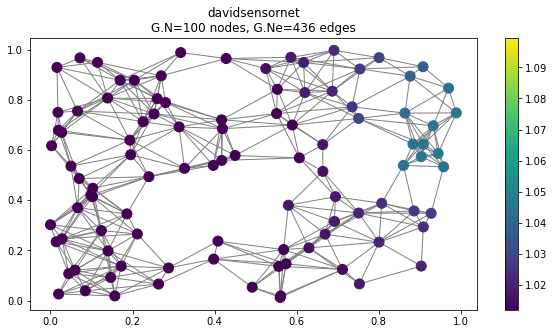

In [14]:
G.plot_signal(f1)
G.plot_signal(f2)
G.plot_signal(f3)

Defining B (repe. U) as the set of nodes with known (resp. unknown) signal values. You should use the signal values of nodes B to interpolate signal values on U.

In [9]:
U = [1, 32, 66, 89]
B = [i for i in range(N) if i not in U]

In [14]:
fU1 = f1[U]
fU2 = f2[U]
fU3 = f3[U]
fB1 = f1[B]
fB2 = f2[B]
fB3 = f3[B]

**What you should do:**


*   **Use cvxpy to interpolate f1, f2 and f3 on U.**
*   **Calculate the Mean Squared Error for each signal.** 
*   **Discuss the effect of signal smoothness on recovery error.**
*   **Use your theoretical solution for interpolation.** 
*   **Compare the theoretical solution with cvxpy .** 

(Bonus) Usually signals are a result of physical measurements and hence are noisy. In such cases it isn't reasonable to have an equality constraint of $g_B = f_B$. One approach that is used in such cases is to solve the following optimzation problem called Tikhonov regularization:
$$\min_{g \in \mathbb{R}^n} g^TLg + \gamma ||Mg - f_B||_2^2$$
Where $M\in\mathbb{R}^{|B|\times n}$ is a downsampling matrix ($Mf = f_B$).

**What you should do:**


*   **Add a gaussian noise to the signals.**
*   **Recover the signals by solving Tikhonov regularization using cvxpy .**
*   **Report the MSE.**
*   **Try different noise levels.**
*   **Report the MSE for different noise levels.**
*   **Discuss the effect of SNR on recovery error.**
*   **Try different values for $\gamma$ and again compare the results (You can plot MSE vs. $γ$).**